Cleaned data loaded
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56651
           1       0.97      0.71      0.82        95

    accuracy                           1.00     56746
   macro avg       0.99      0.85      0.91     56746
weighted avg       1.00      1.00      1.00     56746

Confusion Matrix:
 [[56649     2]
 [   28    67]]


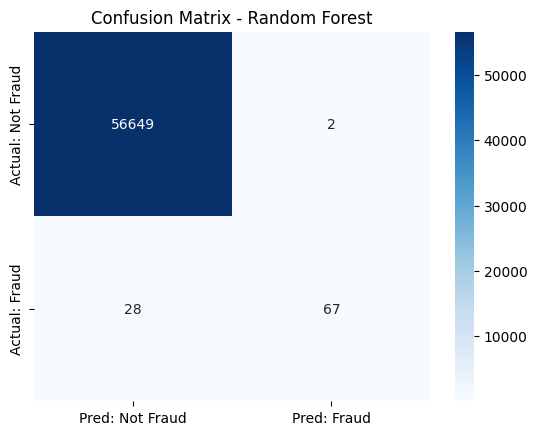

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt

# Load cleaned dataset
df = pd.read_csv('../data/creditcard_cleaned.csv')
print("Cleaned data loaded")

# Separate features and target
X = df.drop(columns=['is_fraud'])
y = df['is_fraud'].astype(int)

# Scale features (optional but safe)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

# Train Random Forest with class balancing
model = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
model.fit(X_train, y_train)

# Predict on test set
y_pred = model.predict(X_test)

# Classification report
print("Classification Report:\n", classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)

# Confusion matrix heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Pred: Not Fraud', 'Pred: Fraud'],
            yticklabels=['Actual: Not Fraud', 'Actual: Fraud'])
plt.title("Confusion Matrix - Random Forest")
plt.show()

## Model Performance Summary

We trained a Random Forest classifier on the cleaned credit card transaction data using class weighting to address class imbalance.

## Confusion Matrix

|                         | Predicted Not Fraud | Predicted Fraud |
|-------------------------|---------------------|-----------------|
| **Actual Not Fraud**    | 56,649 ✅            | 2 ❌ (False Positives) |
| **Actual Fraud**        | 28 ❌ (False Negatives) | 67 ✅ (True Positives) |

- **Total samples**: 56,746  
- **Fraud cases**: 95 (≈0.17%)  
- **Legit cases**: 56,651

---

### Classification Report (Class 1 = Fraud)

| Metric      | Score     |
|-------------|-----------|
| **Precision** | 0.97 ✅  |
| **Recall**    | 0.71 ✅  |
| **F1 Score**  | 0.82 ✅  |
| **Accuracy**  | ~99.8% ✅ |

- **Precision**: Only 2 false alarms out of 69 fraud predictions, very high trustworthiness  
- **Recall**: Caught 71% of actual fraud cases, very solid  
- **F1 Score**: Strong balance between catching fraud and keeping false alarms low

---

### Interpretation

- The model **prioritizes precision**, making it suitable for real-world fraud alert systems where false alarms are expensive.
- **Very low false positive rate** (only 2 out of 56,651 non-fraud cases).
- Slight drop in recall compared to Logistic Regression (which had 0.87), but **far better precision** (0.97 vs 0.06).
- **Training time** was longer (~1.5 min), but performance gain is worth it.

---

### Conclusion

Random Forest strikes a strong balance between **fraud detection and trustworthiness**, making it a solid candidate for deployment or dashboard integration.

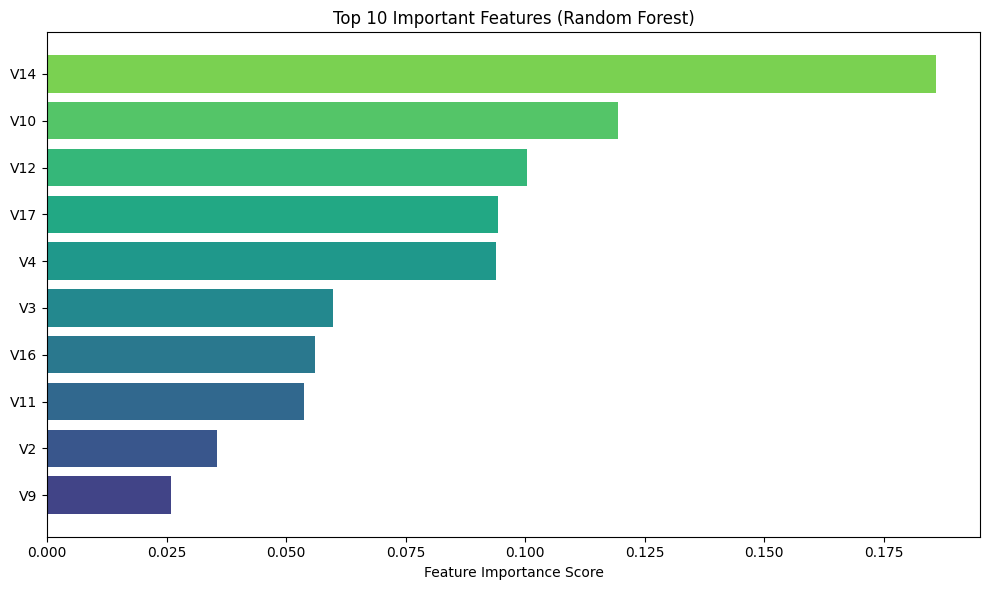

In [2]:
# Feature importance from the trained Random Forest model
importances = model.feature_importances_
feature_names = df.drop(columns=['is_fraud']).columns

# Create a DataFrame for easy plotting
feat_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Plot top 10 features
colors = plt.cm.viridis(np.linspace(0.2, 0.8, 10))  # 10 colors
plt.figure(figsize=(10, 6))
plt.barh(feat_df.head(10)['Feature'][::-1], feat_df.head(10)['Importance'][::-1], color=colors)
plt.title("Top 10 Important Features (Random Forest)")
plt.xlabel("Feature Importance Score")
plt.tight_layout()
plt.show()



## Feature Importance

Understanding **which features the model relies on most** can help us interpret how fraud is being detected and improve model transparency.

The bar chart above shows the **top 10 most important features** used by the Random Forest classifier:

- `V14`, `V10`, and `V12` stand out as the strongest contributors to the model’s decisions.
- These features are part of the anonymized PCA-transformed dataset, so their raw meanings are unknown but their statistical behavior is strongly linked to fraudulent transactions.
- For example, `V14` has been shown in prior studies to often have extremely low values for fraud cases, which aligns with its high importance here.

### Why this matters:

- Feature importance helps validate that the model is learning useful patterns (not noise).
- In regulated environments like banking, interpretability is critical for **model trust** and **auditability**.
- This insight can also guide **feature selection** for simpler or faster models in production.

In future steps, we could complement this with **SHAP values** for local explanations on individual predictions.


In [3]:
# Save trained Random Forest model to disk
import joblib
import os

# Create top-level 'models/' folder if it doesn't exist
output_dir = os.path.join(os.path.dirname(os.getcwd()), "models")
os.makedirs(output_dir, exist_ok=True)

# Save the model
model_path = os.path.join(output_dir, "random_forest_fraud.pkl")
joblib.dump(model, model_path)

print(f"Model saved to {model_path}")

Model saved to c:\Users\ilyas\projects\anomaly-expenses\models\random_forest_fraud.pkl
